# computations of the stitching weights themselves

In [1]:
import numpy as np
import uproot
import hist
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import pickle
from tqdm.auto import tqdm
import sys
import pandas as pd
import matplotlib

In [9]:
input_file_pattern = "/grid_mnt/data__data.polcms/cms/cuisset/cmt/MergeStitchSkim/ul_2018_ZZ_v12/%s_aux/prod_240731/data_0.root"
dataset_names = ["dy"] + [f"dy_ptz{i}" for i in range(1, 6+1)] + ["dy_0j", "dy_1j", "dy_2j"]
def fill_h(h, ar):
    h.fill(LHE_NpNLO=ar["LHE_NpNLOInt"], LHE_Vpt=ar["LHE_Vpt"], weight=ar["genWeight"]/np.average(ar["genWeight"]))
def fill_h_one(h, ar): # fill +1 or -1 as weight 
    h.fill(LHE_NpNLO=ar["LHE_NpNLOInt"], LHE_Vpt=ar["LHE_Vpt"], weight=np.where(ar["genWeight"]>0, 1., -1.))
def fill_h_all(h, ars):
    for ar in ars:
        fill_h(h, ar)
def fill_h_all_one(h, ars):
    for ar in ars:
        fill_h_one(h, ar)

def make_hist():
    return hist.Hist(
        hist.axis.Integer(0, 5, name="LHE_NpNLO"),
        hist.axis.Variable([sys.float_info.epsilon, 50, 100, 250, 400, 650], name="LHE_Vpt", underflow=True, overflow=True),
        storage="weight"
    )

In [10]:
ars = {}
for dataset in tqdm(dataset_names):
    ars[dataset] = uproot.open(input_file_pattern % dataset + ":Events").arrays(library="np")
ars

{'dy': {'genWeight': array([ 25259.674,  25259.674,  25259.674, ..., -25259.674,  25259.674,
          25259.674], dtype=float32),
  'LHE_NpNLOInt': array([0, 0, 0, ..., 0, 0, 1], dtype=int32),
  'LHE_Vpt': array([ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     , 73.10541],
        dtype=float32)},
 'dy_ptz1': {'genWeight': array([ 24238.383,  24238.383, -24238.383, ..., -24238.383,  24238.383,
          24238.383], dtype=float32),
  'LHE_NpNLOInt': array([0, 1, 2, ..., 1, 1, 0], dtype=int32),
  'LHE_Vpt': array([23.780132, 33.272827, 28.539587, ..., 46.49401 , 47.645054,
         19.4711  ], dtype=float32)},
 'dy_ptz2': {'genWeight': array([ 11319.365, -11319.365,  11319.365, ...,  11319.365, -11319.365,
          11319.365], dtype=float32),
  'LHE_NpNLOInt': array([2, 2, 1, ..., 2, 2, 2], dtype=int32),
  'LHE_Vpt': array([70.46696 , 58.82869 , 55.051384, ..., 99.06009 , 89.12001 ,
         75.3326  ], dtype=float32)},
 'dy_ptz3': {'genWeight': array([1491.0223, 1491.0223, 1491.0

In [11]:
hs = {}
for dataset, vals in ars.items():
    h = make_hist()
    fill_h(h, vals)
    hs[dataset] = h

In [18]:
hs["dy_2j"].sum(True).value, len(ars["dy_2j"]["genWeight"])

(1147246.8701574802, 1147247)

In [59]:
hs["dy_ptz1"].values(True)[1:-1, 0].shape

(5,)

In [78]:

from mplhep.utils import (
    get_histogram_axes_title,
    get_plottable_protocol_bins,
    hist_object_handler,
    isLight,
    process_histogram_parts,
)
from mplhep.plot import append_axes, ColormeshArtists
def my2DPlot(hist:hist.Hist, ax=None, **kwargs):
     # ax check
    if ax is None:
        ax = plt.gca()
    else:
        if not isinstance(ax, plt.Axes):
            raise ValueError("ax must be a matplotlib Axes object")

    H = hist.values()
    xbins, xtick_labels = get_plottable_protocol_bins(hist.axes[0])
    ybins, ytick_labels = get_plottable_protocol_bins(hist.axes[1])

    # overflow y (ptZ)
    padded = np.zeros((H.shape[0], H.shape[1] + 2))
    padded[:, 1:-1] = H
    padded[:, 0] = hist.values(True)[1:-1, 0]
    padded[:, -1] = hist.values(True)[1:-1, -1]
    xbins, ybins = xbins, np.r_[ybins[0] - 50, ybins, ybins[-1] + 50]
    H = padded

    
    xbin_centers = xbins[1:] - np.diff(xbins) / float(2)
    ybin_centers = ybins[1:] - np.diff(ybins) / float(2)

    _x_axes_label = ax.get_xlabel()
    x_axes_label = (
        _x_axes_label if _x_axes_label != "" else get_histogram_axes_title(hist.axes[0])
    )
    _y_axes_label = ax.get_ylabel()
    y_axes_label = (
        _y_axes_label if _y_axes_label != "" else get_histogram_axes_title(hist.axes[1])
    )

    H = H.T
    X, Y = np.meshgrid(xbins, ybins)
    kwargs.setdefault("shading", "flat")
    pc = ax.pcolormesh(X, Y, H, **kwargs)

    if x_axes_label:
        ax.set_xlabel(x_axes_label)
    if y_axes_label:
        ax.set_ylabel(y_axes_label)

    ax.set_xlim(xbins[0], xbins[-1])
    ax.set_ylim(ybins[0], ybins[-1])

    if xtick_labels is None:  # Ordered axis
        if len(ax.get_xticks()) > len(xbins) * 0.7:
            ax.set_xticks(xbins)
    else:  # Categorical axis
        ax.set_xticks(xbin_centers)
        ax.set_xticklabels(xtick_labels)
    if ytick_labels is None:
        if len(ax.get_yticks()) > len(ybins) * 0.7:
            ax.set_yticks(ybins)
    else:  # Categorical axis
        ax.set_yticks(ybin_centers)
        ax.set_yticklabels(ytick_labels)

    cbarsize="7%"
    cbarpad=0.2
    cbarpos="right"
    cax = append_axes(
        ax, size=cbarsize, pad=cbarpad, position=cbarpos, extend=False
    )
    cb_obj = plt.colorbar(pc, cax=cax)

    plt.sca(ax)

    _labels: np.ndarray | None = None
    _labels = H

    text_artists = []
    for ix, xc in enumerate(xbin_centers):
        for iy, yc in enumerate(ybin_centers):
            color = (
                "black"
                if isLight(pc.cmap(pc.norm(H[iy, ix]))[:-1])
                else "lightgrey"
            )
            val = _labels[iy, ix]
            text_artists.append(
                ax.text(
                    xc, yc, "{:.1e}".format(val) if val > 9.5 else "{:.1f}".format(val), ha="center", va="center", color=color
                )
            )

    return ColormeshArtists(pc, cb_obj, text_artists)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7eff657d1c90>, cbar=<matplotlib.colorbar.Colorbar object at 0x7eff675c83d0>, text=[Text(0.5, -25.0, '0.0'), Text(0.5, 25.0, '0.0'), Text(0.5, 75.0, '0.0'), Text(0.5, 175.0, '0.0'), Text(0.5, 325.0, '0.0'), Text(0.5, 525.0, '0.0'), Text(0.5, 675.0, '7.9e+01'), Text(1.5, -25.0, '0.0'), Text(1.5, 25.0, '0.0'), Text(1.5, 75.0, '0.0'), Text(1.5, 175.0, '0.0'), Text(1.5, 325.0, '0.0'), Text(1.5, 525.0, '0.0'), Text(1.5, 675.0, '6.3e+05'), Text(2.5, -25.0, '0.0'), Text(2.5, 25.0, '0.0'), Text(2.5, 75.0, '0.0'), Text(2.5, 175.0, '0.0'), Text(2.5, 325.0, '0.0'), Text(2.5, 525.0, '0.0'), Text(2.5, 675.0, '3.4e+06'), Text(3.5, -25.0, '0.0'), Text(3.5, 25.0, '0.0'), Text(3.5, 75.0, '0.0'), Text(3.5, 175.0, '0.0'), Text(3.5, 325.0, '0.0'), Text(3.5, 525.0, '0.0'), Text(3.5, 675.0, '0.0'), Text(4.5, -25.0, '0.0'), Text(4.5, 25.0, '0.0'), Text(4.5, 75.0, '0.0'), Text(4.5, 175.0, '0.0'), Text(4.5, 325.0, '0.0'), Text(4.5, 525.0, 

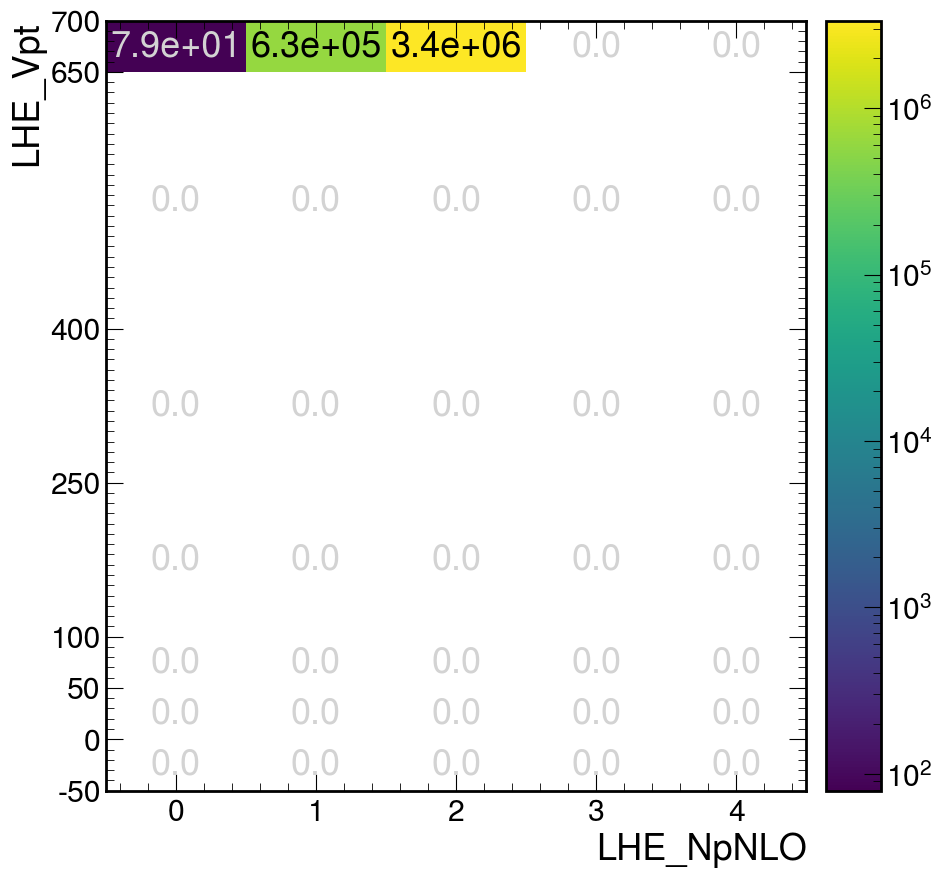

In [79]:
my2DPlot(hs["dy_ptz6"],  norm=matplotlib.colors.LogNorm())

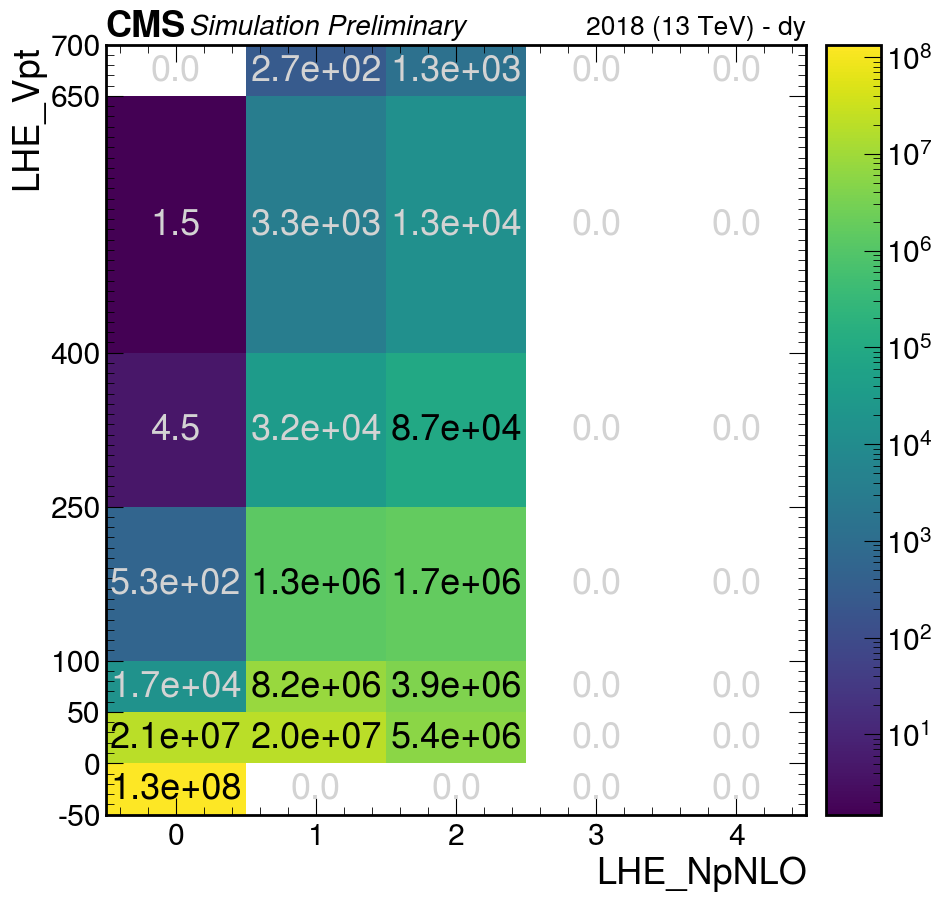

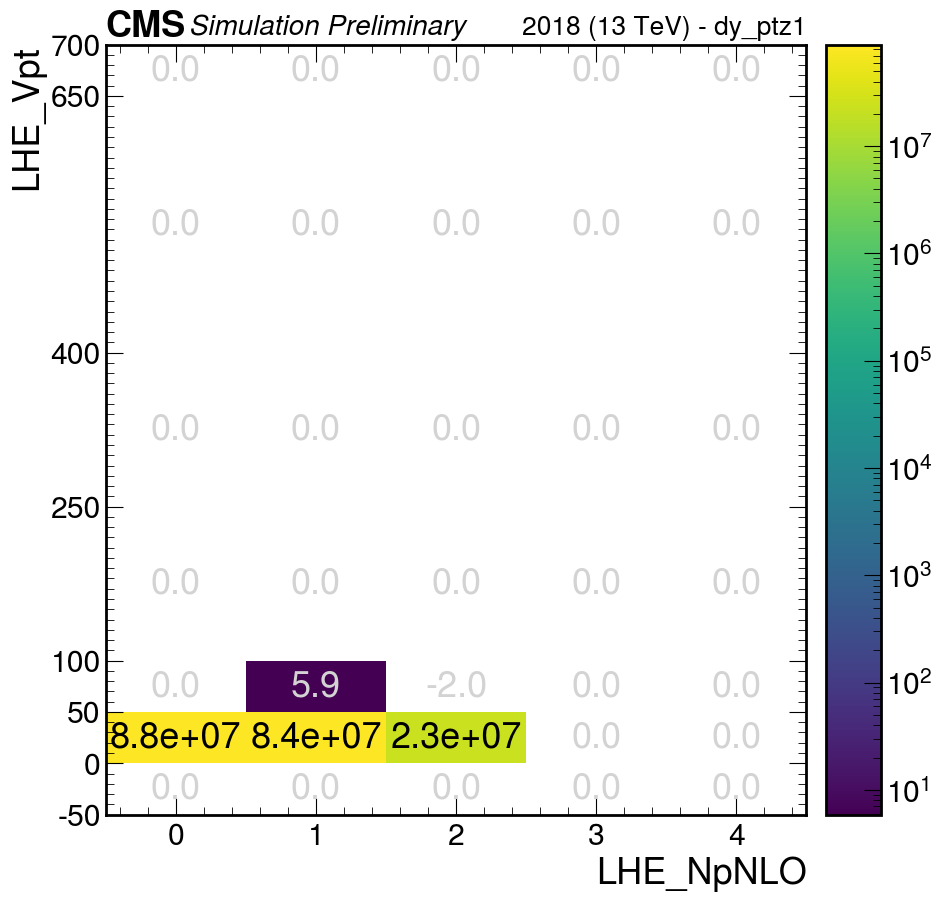

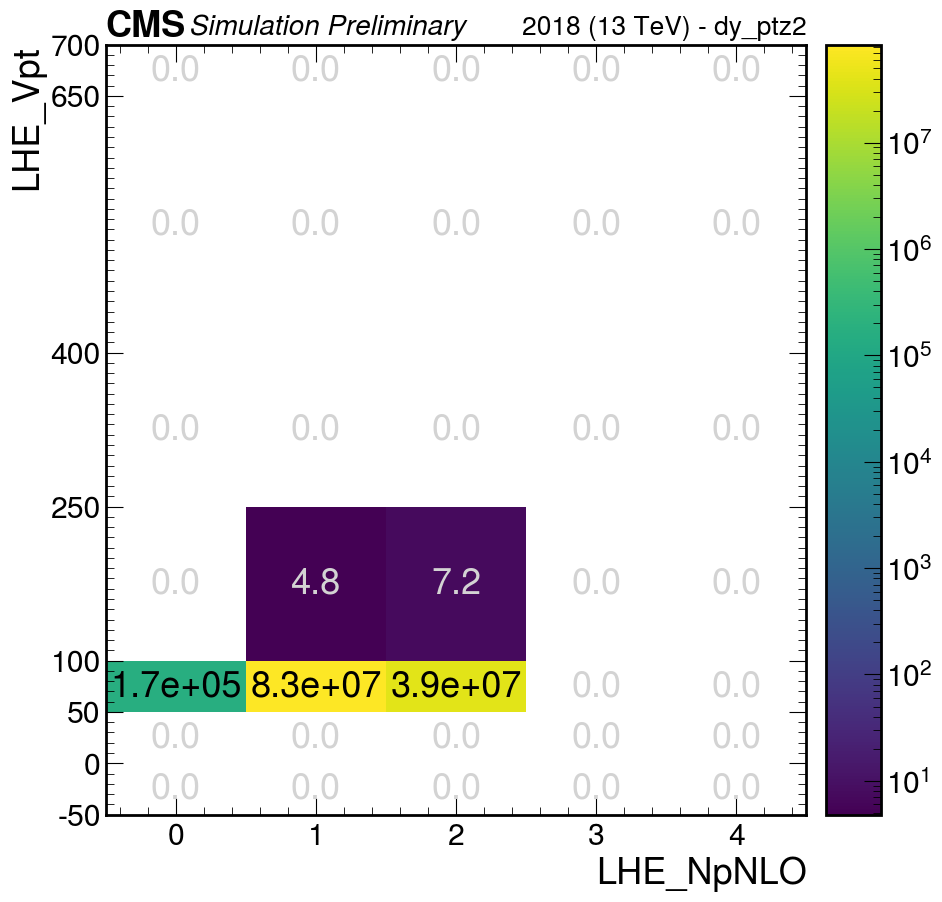

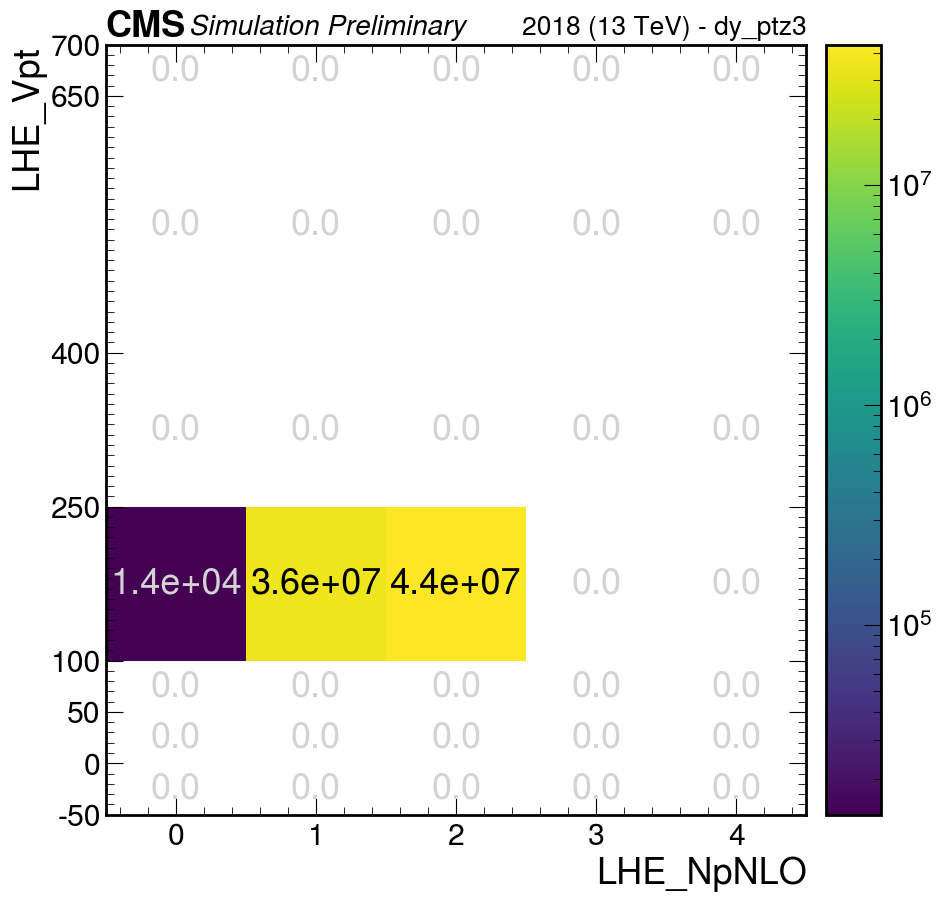

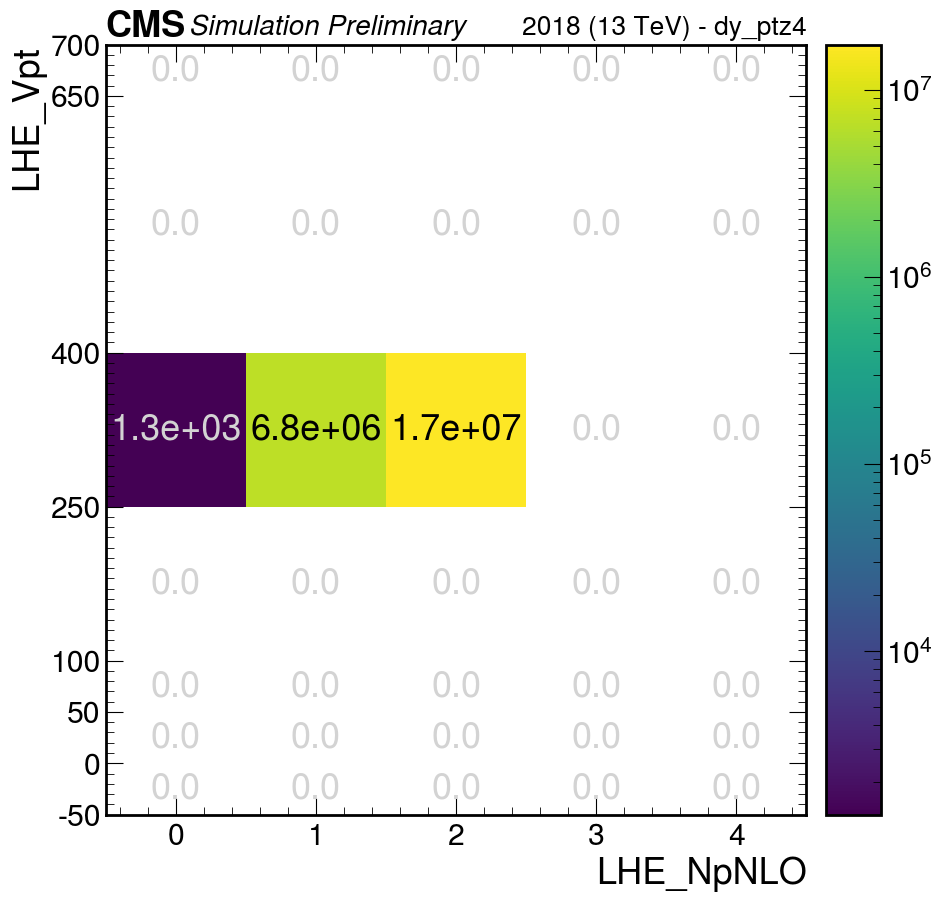

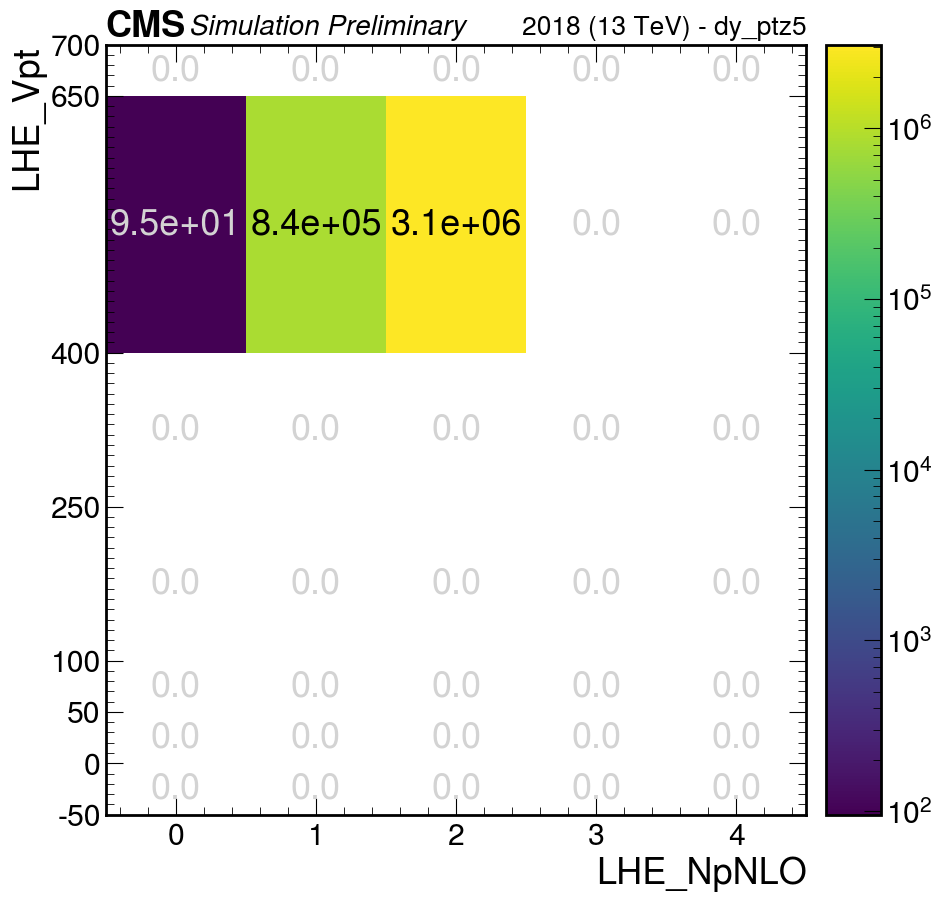

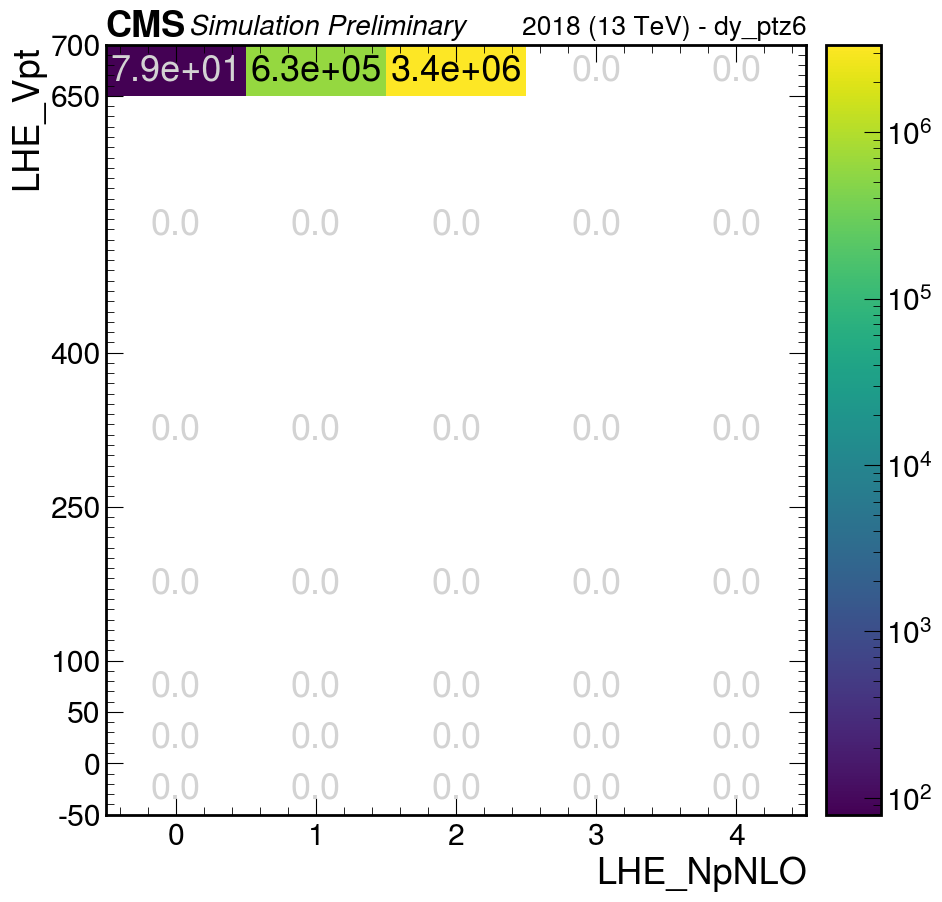

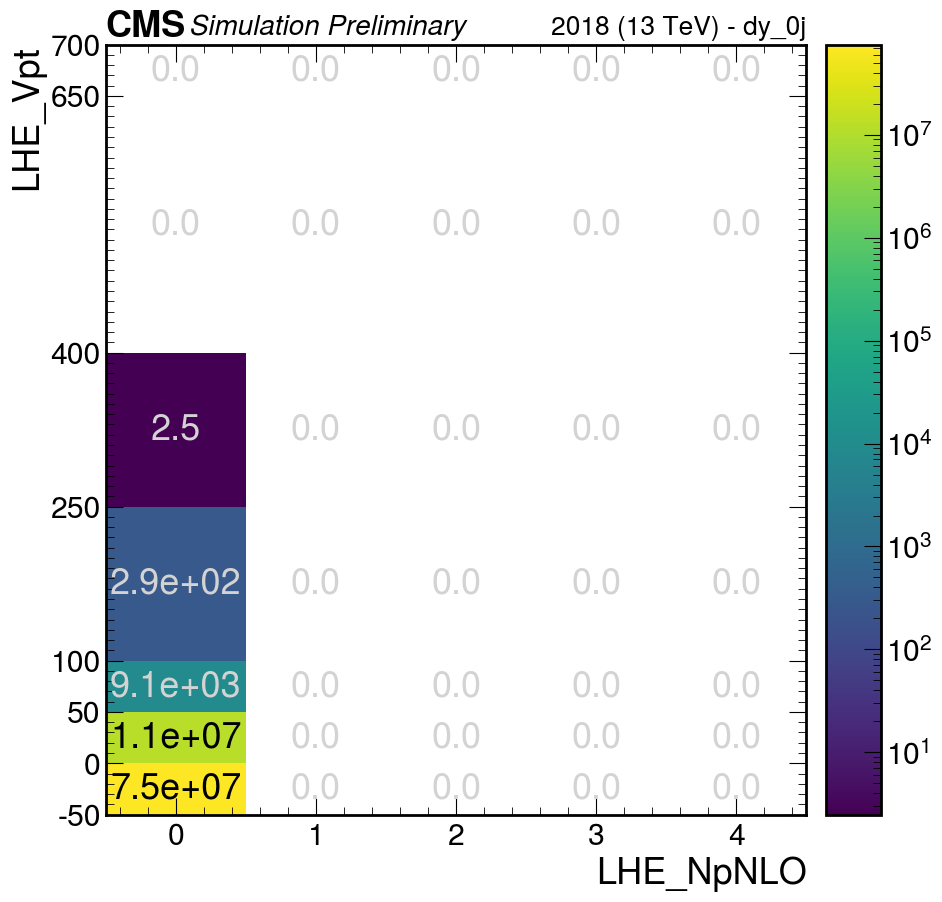

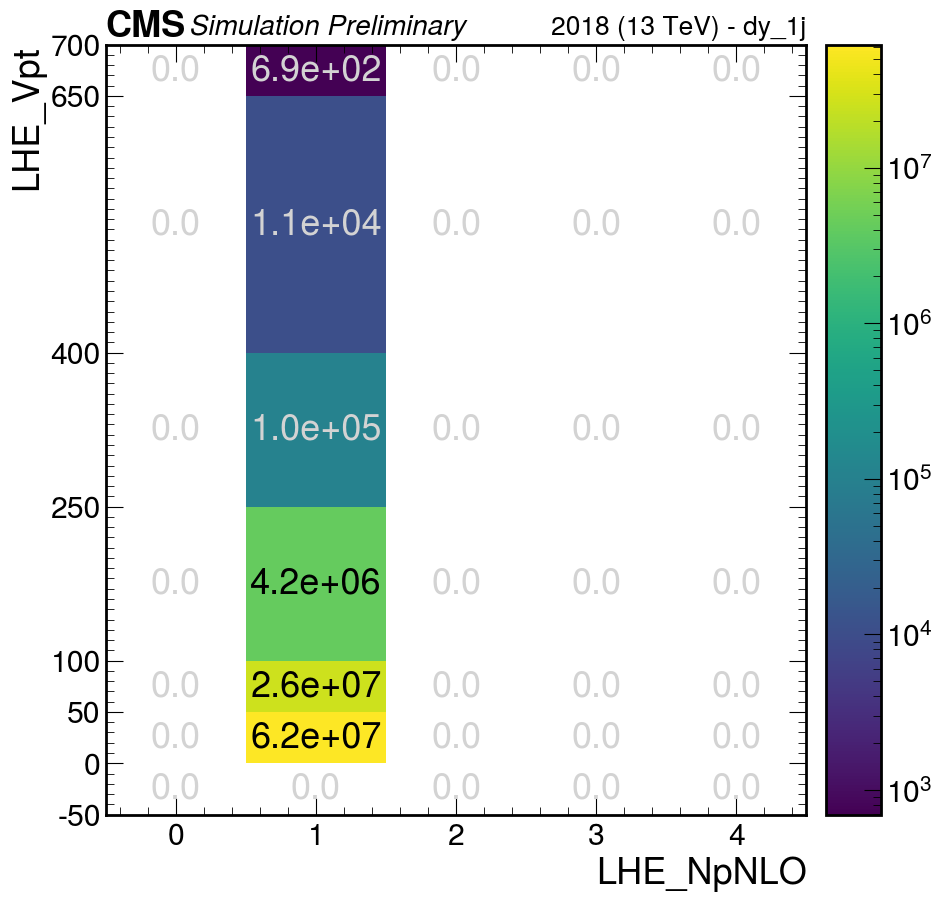

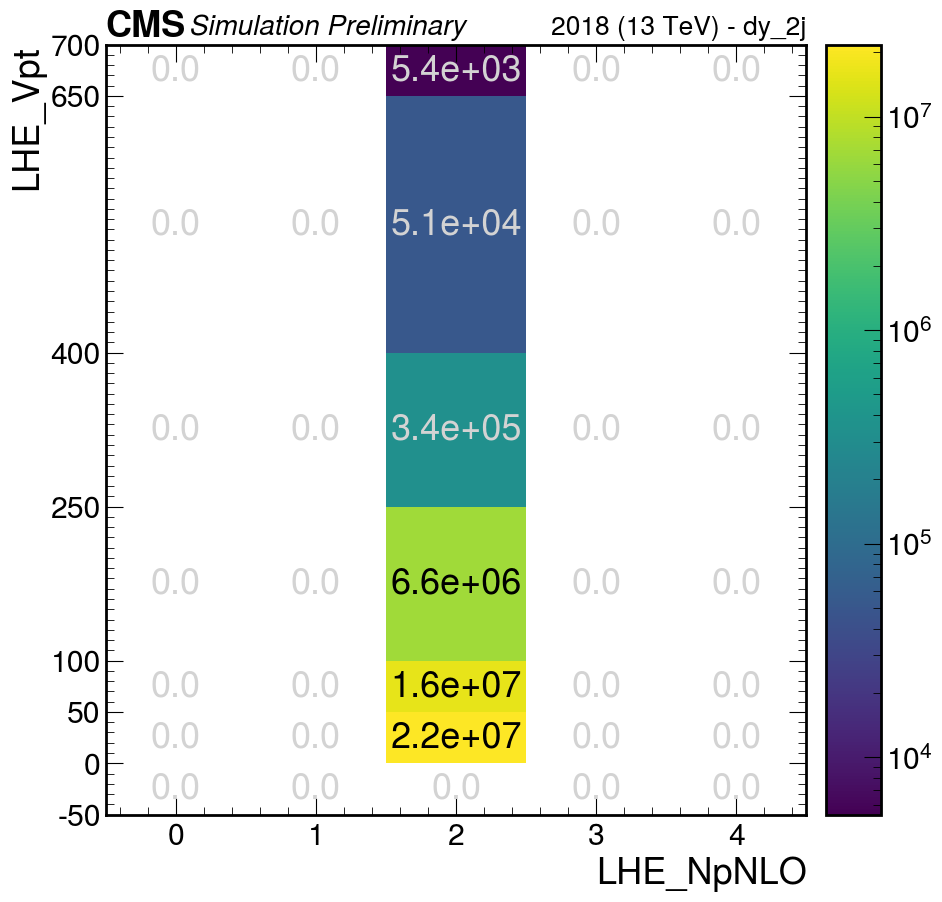

In [82]:
for dataset in dataset_names:
    plt.figure()
    my2DPlot(hs[dataset],  norm=matplotlib.colors.LogNorm())
    hep.cms.text("Simulation Preliminary", fontsize=20)
    hep.cms.lumitext(f"2018 (13 TeV) - " + dataset, fontsize=20)


In [84]:
datasets_toStitch = hs.keys()
#datasets_toStitch = ["incl", "dy_ptz5"]
def Pij(LHE_NpNLO, LHE_Vpt_bin, dataset):
    """ LHE_NpNLO (actual nb), LHE_Vpt_bin (bin number) = i, dataset = j"""
    h = hs[dataset]
    return h[dict(LHE_NpNLO=hist.loc(LHE_NpNLO), LHE_Vpt=LHE_Vpt_bin)].value / h.sum(flow=True).value

def s_i(LHE_NpNLO, LHE_Vpt_bin):
    """ WITHOUT lumi & incl cross-section """
    try:
        return Pij(LHE_NpNLO, LHE_Vpt_bin, "dy") / sum((Pij(LHE_NpNLO, LHE_Vpt_bin, dataset) * hs[dataset].sum(flow=True).value for dataset in datasets_toStitch))
    except ZeroDivisionError:
        return 0

s_matrix = np.zeros((3, 7)) # x  NpNLO 0 to 2, y : PtZ 0, 0to50, 50to100, 100to250, 250to400, 400to650, GreaterThan650
for LHE_NpNLO in range(3):
    s_matrix[LHE_NpNLO, 0] = s_i(LHE_NpNLO, hist.underflow)
    for LHE_Vpt_bin in range(0, 4+1):
        s_matrix[LHE_NpNLO, LHE_Vpt_bin+1] = s_i(LHE_NpNLO, LHE_Vpt_bin)
    s_matrix[LHE_NpNLO, 6] = s_i(LHE_NpNLO, hist.overflow)
s_matrix

array([[3.28602946e-09, 8.71013786e-10, 4.38392706e-10, 1.87293960e-10,
        1.69980910e-11, 7.84203702e-11, 0.00000000e+00],
       [0.00000000e+00, 6.03364285e-10, 3.57719194e-10, 1.63316123e-10,
        2.37783924e-11, 1.97888178e-11, 2.18995778e-12],
       [0.00000000e+00, 5.48303471e-10, 3.41683228e-10, 1.64767666e-10,
        2.49955981e-11, 2.14846115e-11, 1.95932236e-12]])

In [42]:
# cross-check with GenXSECAnalyzer with dy_1j
sum(Pij(1, Vpt_bin, "incl") for Vpt_bin in [hist.underflow, hist.overflow] + list(range(3+1))),  983.5/6424.0

(0.14921547555005082, 0.15309775840597759)

In [43]:
# cross-check with GenXSECAnalyzer with dy_ptz6
sum(Pij(LHE_NpNLO, hist.overflow, "incl") for LHE_NpNLO in range(3)),  0.040981055/6424.0

(8.322141137821027e-06, 6.379367216687422e-06)

In [44]:
ht = hist.Hist(hist.axis.Variable([sys.float_info.epsilon, 1, 2], underflow=True, overflow=True)).fill([-1, 0])
ht.values(True)

array([2., 0., 0., 0.])

In [86]:
def df_make_bin_i(df):
    return df.assign(
        LHE_Vpt_bin = pd.cut(df.LHE_Vpt, [-1, 0, 50, 100, 250, 400, 650, float("inf")], labels=False)
    )
def df_get_s(df, s_matrix):
    return df.assign(
        s=s_matrix[df.LHE_NpNLOInt, df.LHE_Vpt_bin]
    )
def df_makeGenWeightNorm(df):
    return df.assign(
        genWeightNorm=df.genWeight / np.average(df.genWeight)
    )
dfs = {dataset : df_makeGenWeightNorm(df_get_s(df_make_bin_i(pd.DataFrame(x)), s_matrix)) for dataset, x in tqdm(ars.items())}

In [47]:
dfs["incl"]

,genWeight,LHE_NpNLOInt,LHE_Vpt,LHE_Vpt_bin,s,genWeightNorm
0,25259.673828,0,0.000000,0,1.772886e-08,1.485999
1,25259.673828,0,0.000000,0,1.772886e-08,1.485999
2,25259.673828,0,0.000000,0,1.772886e-08,1.485999
3,25259.673828,0,24.178734,1,1.621016e-08,1.485999
4,25259.673828,0,0.000000,0,1.772886e-08,1.485999
...,...,...,...,...,...,...
54817930,-25259.673828,1,41.489891,1,1.459654e-08,-1.485999
54817931,25259.673828,0,25.172276,1,1.621016e-08,1.485999
54817932,25259.673828,0,0.000000,0,1.772886e-08,1.485999
54817933,25259.673828,2,255.664566,4,5.867796e-10,1.485999


In [89]:
lumi = 59741
xs = {
    "dy":               6424.0,                   # XSDB : TODO use value from https://twiki.cern.ch/twiki/bin/viewauth/CMS/StandardModelCrossSectionsat13TeV maybe ?
    "dy_ptz1":          1485.0,                   # XSDB
    "dy_ptz2":          397.4,                    # XSDB
    "dy_ptz3":          97.2,                     # XSDB
    "dy_ptz4":          3.701,                    # XSDB
    "dy_ptz5":          0.5086,                   # XSDB
    "dy_ptz6":          0.040981055,              # XSDB
    "dy_0j":            5090.0,                   # XSDB
    "dy_1j":            983.5,                    # XSDB
    "dy_2j":            353.6,                    # XSDB
}
lhe_vpt_axis_low = hist.axis.Regular(300, 0.,  100, name="LHE_Vpt")
lhe_vpt_axis_high = hist.axis.Regular(100, 1.,  1000, name="LHE_Vpt", transform=hist.axis.transform.log)

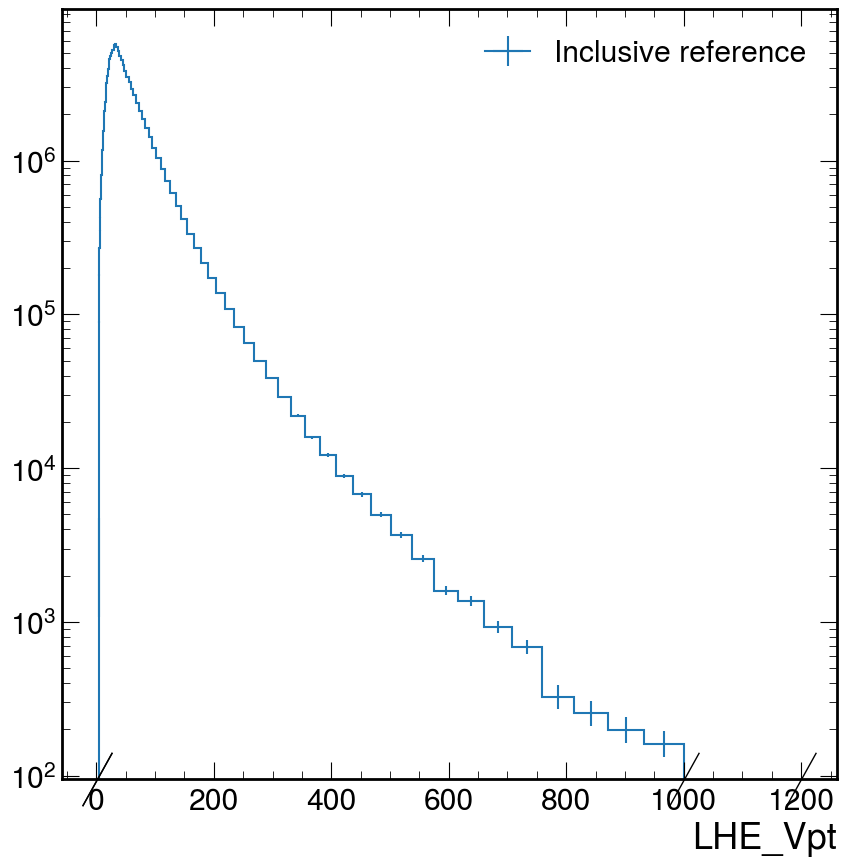

In [183]:
h_ref_high = hist.Hist(lhe_vpt_axis_high, storage="weight").fill(dfs["dy"].LHE_Vpt, weight=dfs["dy"].genWeight)*lumi*xs["dy"] / dfs["dy"].genWeight.sum()
h_ref_low = hist.Hist(lhe_vpt_axis_low, storage="weight").fill(dfs["dy"].LHE_Vpt, weight=dfs["dy"].genWeight)*lumi*xs["dy"] / dfs["dy"].genWeight.sum()
hep.histplot(h_ref_high, label="Inclusive reference")
plt.yscale("log")
plt.legend()

In [93]:
h_plots_high = {}
h_plots_low = {}
h_plots_noS = {}
for dataset, df in dfs.items():
    if dataset not in datasets_toStitch:
        continue
    h_plots_high[dataset] = hist.Hist(lhe_vpt_axis_high, storage="weight").fill(dfs[dataset].LHE_Vpt, weight=dfs[dataset].s*dfs[dataset].genWeightNorm)*lumi*xs["dy"]
    h_plots_low[dataset] = hist.Hist(lhe_vpt_axis_low, storage="weight").fill(dfs[dataset].LHE_Vpt, weight=dfs[dataset].s*dfs[dataset].genWeightNorm)*lumi*xs["dy"]
    h_plots_noS[dataset] = hist.Hist(lhe_vpt_axis_high, storage="weight").fill(dfs[dataset].LHE_Vpt, weight=dfs[dataset].genWeightNorm)*lumi*xs[dataset]/dfs[dataset].genWeightNorm.sum()

In [113]:
matplotlib.colormaps["tab10"].colors

((0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529))

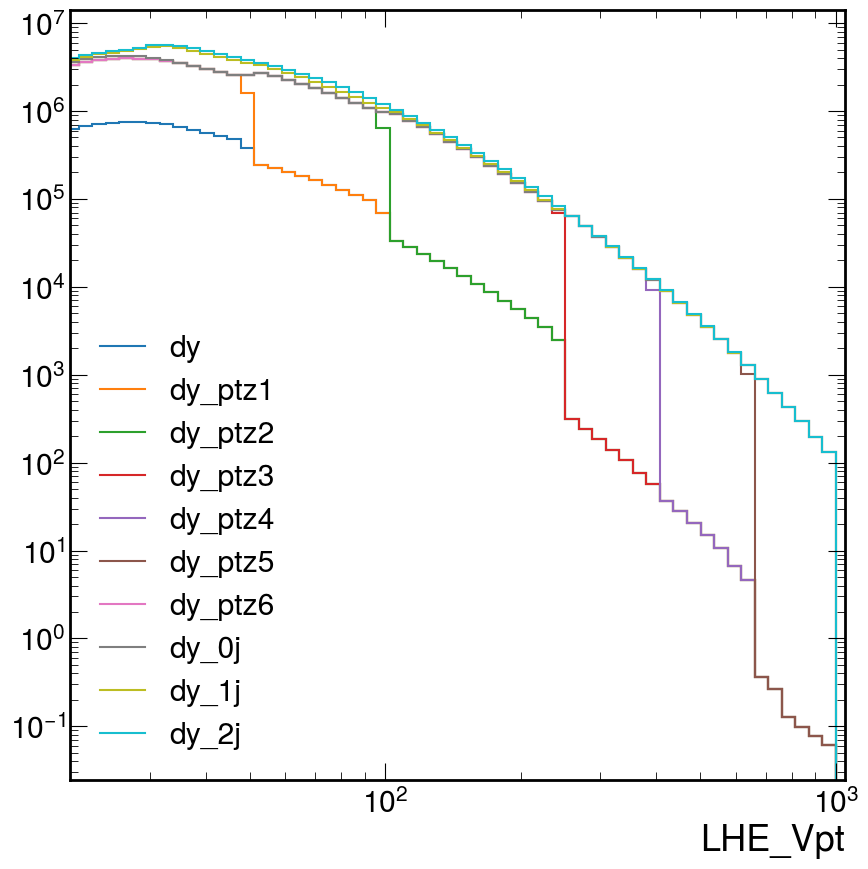

In [114]:
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=matplotlib.colormaps["tab10"].colors)
hep.histplot(list(h_plots_high.values()), label=h_plots_high.keys(), stack=True, yerr=False, flow="none")
plt.xlim(left=20)
#hep.histplot(h_ref_high, label="Incl. reference")
plt.yscale("log")
plt.xscale("log")
plt.legend()

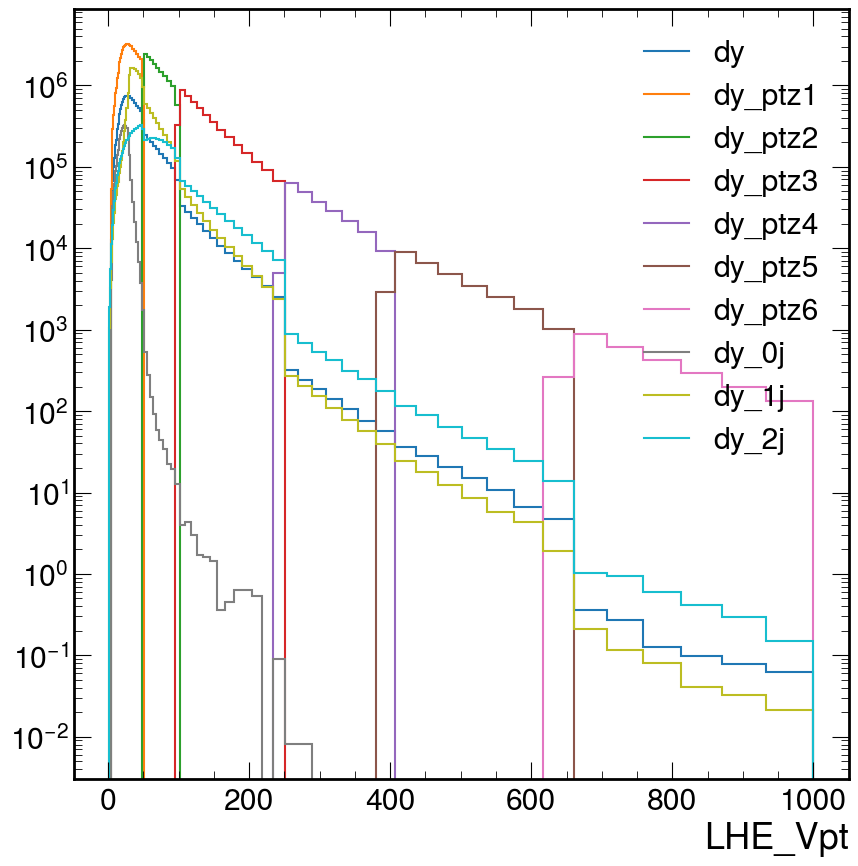

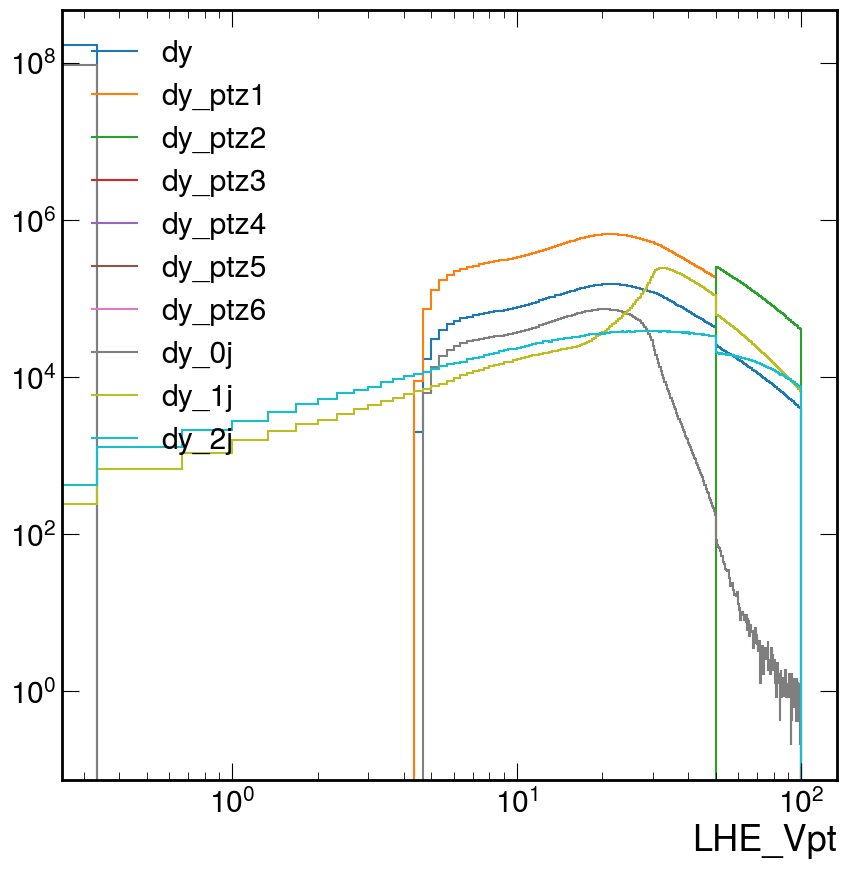

In [121]:
"nostack"
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=matplotlib.colormaps["tab10"].colors)
hep.histplot(list(h_plots_high.values()), label=h_plots_high.keys(), stack=False, yerr=False, flow="none")
# hep.histplot(h_ref_high, label="Incl. reference")
plt.yscale("log")
#plt.xscale("log")
plt.legend()

plt.figure()
"nostack"
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=matplotlib.colormaps["tab10"].colors)
hep.histplot(list(h_plots_low.values()), label=h_plots_low.keys(), stack=False, yerr=False, flow="none")
# hep.histplot(h_ref_high, label="Incl. reference")
plt.yscale("log")
plt.xscale("log")
plt.legend()

## pretty plots with ratio

In [99]:
h_ref_high.values()*h_ref_high.values()/h_ref_high.variances()

array([1.01307872e+04, 1.13096694e+04, 1.33727272e+04, 1.47112846e+04,
       1.68489748e+04, 1.87641736e+04, 2.11123988e+04, 2.31130788e+04,
       2.60049590e+04, 2.93449903e+04, 3.13489915e+04, 3.45045747e+04,
       3.66141718e+04, 3.82671153e+04, 3.84984178e+04, 3.76236911e+04,
       3.40141886e+04, 2.70873055e+04, 1.92873135e+04, 1.01651331e+04,
       2.72779692e+03, 2.91168083e+00, 3.69877844e+03, 1.34530033e+04,
       2.74574902e+04, 4.36834303e+04, 6.00207491e+04, 7.77876431e+04,
       9.63134951e+04, 1.17004909e+05, 1.41084689e+05, 1.69591165e+05,
       2.04369213e+05, 2.41313301e+05, 2.85673456e+05, 3.35759097e+05,
       4.00055258e+05, 4.70811430e+05, 5.50745730e+05, 6.41158916e+05,
       7.34246165e+05, 8.33730186e+05, 9.24710910e+05, 1.00070156e+06,
       1.04873617e+06, 1.06705409e+06, 1.05752836e+06, 1.01900295e+06,
       9.73796535e+05, 9.59622587e+05, 9.08663024e+05, 8.44078927e+05,
       7.75540795e+05, 7.14452095e+05, 6.57043050e+05, 6.07503468e+05,
      

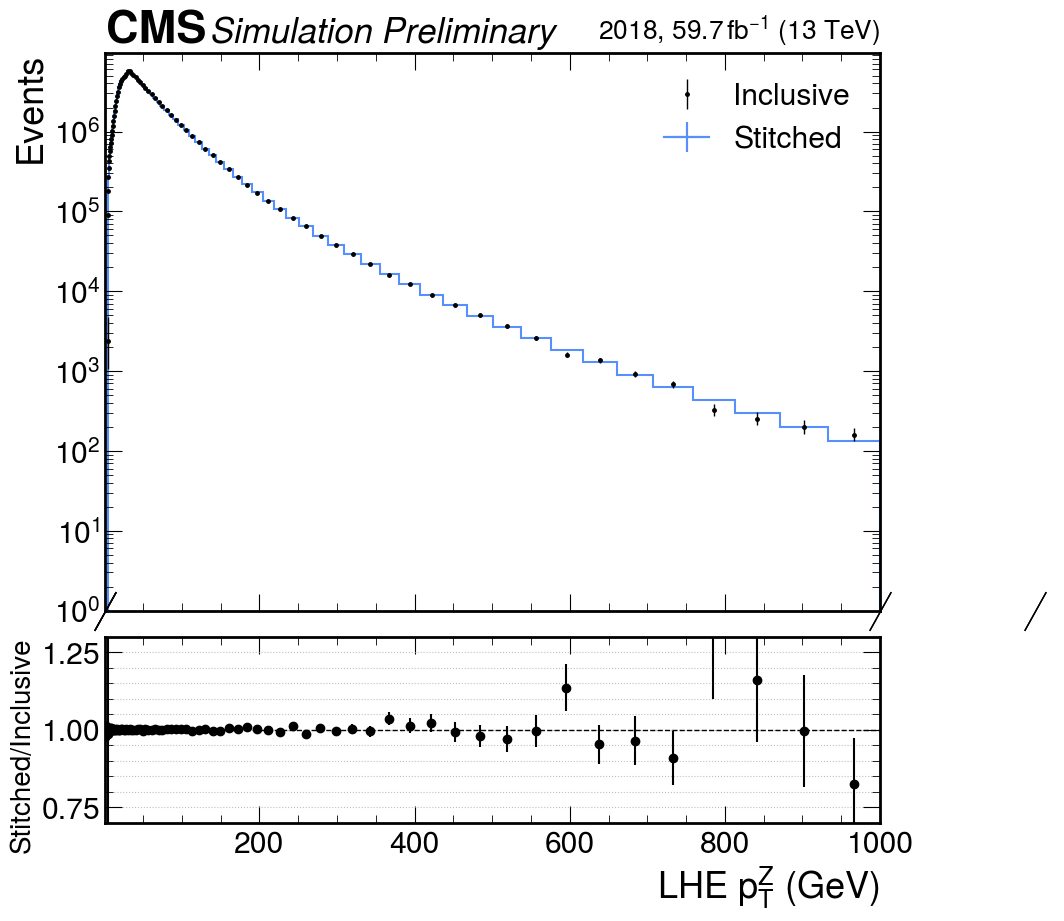

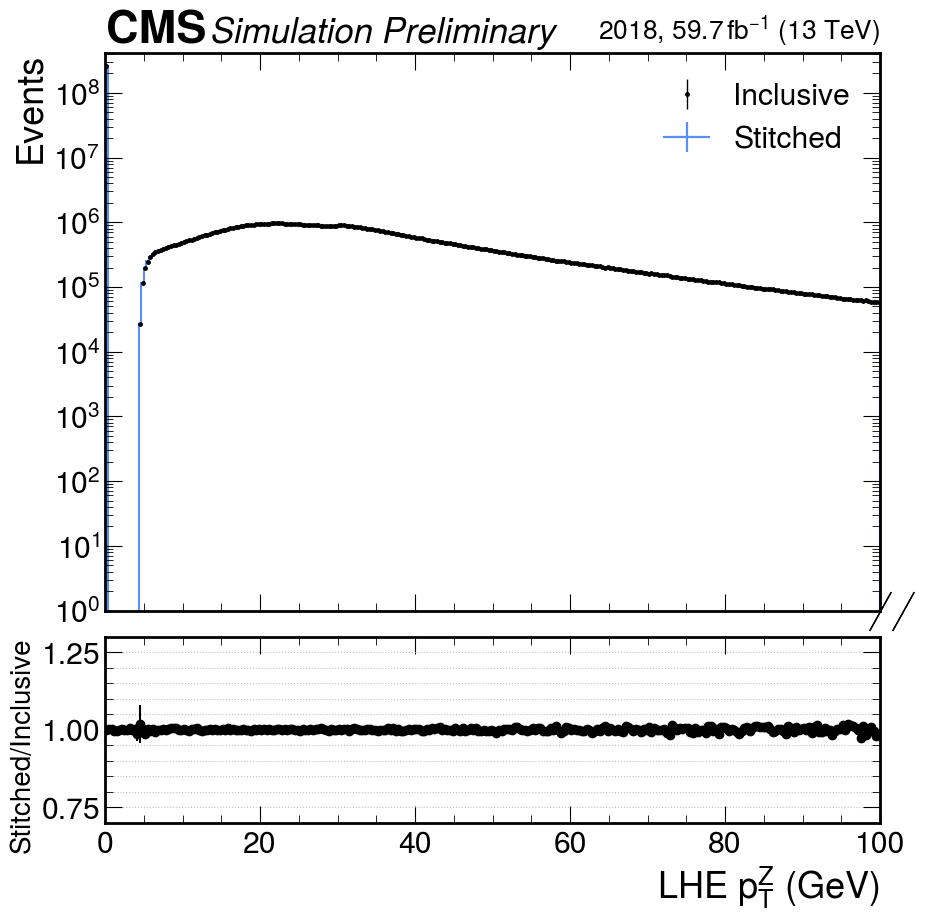

In [100]:
import hist.plot
def plot_ratio(h_plots, inclusive_h):
    fig = plt.figure()
    grid = fig.add_gridspec(2, 1, hspace=0.07, height_ratios=[3, 1])

    main_ax:plt.Axes = fig.add_subplot(grid[0])
    subplot_ax:plt.Axes = fig.add_subplot(grid[1], sharex=main_ax)

    h_stitched = sum(h_plots.values())
    stitched_artist = hep.histplot(h_stitched, yerr=True, label="Stitched", ax=main_ax)
    incl_artist = hep.histplot(inclusive_h, label="Inclusive", yerr=True, histtype="errorbar", color="black", markersize=5, ax=main_ax)

    with np.errstate(divide="ignore", invalid="ignore"):
            ratio = h_stitched.values() / inclusive_h.values()
            uncert = ratio*np.sqrt(h_stitched.variances()/(h_stitched.values()*h_stitched.values()) + inclusive_h.variances()/(inclusive_h.values()*inclusive_h.values()))
            # with negative weights ratio is not trivial to compute
            hist.plot.plot_ratio_array(h_stitched, ratio, uncert, subplot_ax, ylim=(0.8,1.2), markersize=5)
        # hep.histplot(ratio, yerr=False, histtype="errorbar", ax=subplot_ax)
    
    main_ax.set_yscale("log")
    main_ax.set_ylim(bottom=1)
    subplot_ax.set_ylim(0.7, 1.3)
    # if suffix == "":
    #     plt.xlim(0, 1e3)
    plt.setp(main_ax.get_xticklabels(), visible=False)
    main_ax.legend(incl_artist + stitched_artist, ["Inclusive", "Stitched"])
    main_ax.set_xlabel("")
    subplot_ax.set_xlabel("LHE $p_T^Z$ (GeV)")
    subplot_ax.grid(axis="y", which="both")
    subplot_ax.set_ylabel("Stitched/Inclusive", size=20)
    main_ax.set_ylabel("Events")
    hep.cms.text("Simulation Preliminary", fontsize=25, ax=main_ax)
    lumi = 59741
    hep.cms.lumitext(f"2018, ${lumi/ 1000:.1f}\/""fb^{-1}$ (13 TeV)", fontsize=20, ax=main_ax)

plot_ratio(h_plots_high, h_ref_high)
plot_ratio(h_plots_low, h_ref_low)

## correctionlib

In [2]:
import correctionlib.schemav2 as cs

In [151]:
corr = cs.Correction(
    name="drellYanStitchWeight",
    description="Drell-Yan stitching weights for 2018 UL (inclusive, PtZ-binned, njets-binned)",
    version=1,
    inputs=[
        cs.Variable(name="LHE_NpNLO", type="int"),
        cs.Variable(name="LHE_Vpt", type="real", description="Z boson pT at LHE (can be zero)")
    ],
    output=cs.Variable(name="weight", type="real", description="Stitching weight"),
    data=cs.Category(
        nodetype='category',
        input='LHE_NpNLO',
        content=[
            cs.CategoryItem(
                key=LHE_NpNLO,
                value=cs.Binning(
                    nodetype='binning',
                    input='LHE_Vpt',
                    # the PtZ=0 needs to be included
                    edges=[-1e-10, 1e-10, 50.0, 100.0, 250.0, 400.0, 650.0],
                    content=s_matrix[LHE_NpNLO, :-1],
                    flow=s_matrix[LHE_NpNLO, -1]
                )
            )
            for LHE_NpNLO in range(0, 2+1)
        ]
    )
)

In [179]:
import itertools
for LHE_NpNLO, LHE_Vpt in itertools.product([0, 1, 2], [0., 10., 101., 800.]):
    print(LHE_NpNLO, LHE_Vpt, corr.to_evaluator().evaluate(LHE_NpNLO, LHE_Vpt), s_matrix[LHE_NpNLO, pd.cut([LHE_Vpt], [-1, 0, 50, 100, 250, 400, 650, float("inf")], labels=False)[0]])

0 0.0 3.286029457188628e-09 3.286029457188628e-09
0 10.0 8.710137862422122e-10 8.710137862422122e-10
0 101.0 1.8729395976977464e-10 1.8729395976977464e-10
0 800.0 0.0 0.0
1 0.0 0.0 0.0
1 10.0 6.033642850757623e-10 6.033642850757624e-10
1 101.0 1.633161229177934e-10 1.633161229177934e-10
1 800.0 2.1899577849111872e-12 2.1899577849111872e-12
2 0.0 0.0 0.0
2 10.0 5.483034714856863e-10 5.483034714856863e-10
2 101.0 1.6476766628651523e-10 1.6476766628651525e-10
2 800.0 1.959322356114004e-12 1.959322356114004e-12


In [175]:
LHE_NpNLO, LHE_Vpt = 0, 100.

In [176]:
s_matrix[LHE_NpNLO, :]

array([3.28602946e-09, 8.71013786e-10, 4.38392706e-10, 1.87293960e-10,
       1.69980910e-11, 7.84203702e-11, 0.00000000e+00])

In [178]:
corr.to_evaluator().evaluate(LHE_NpNLO, 100.)

1.8729395976977464e-10

## Checking correctionlib

In [15]:
import correctionlib, math
cs = correctionlib.CorrectionSet.from_file("/grid_mnt/data__data.polcms/cms/cuisset/ZHbbtautau/frameworkJobs/nanoaod_base_analysis/data/cmssw/CMSSW_12_3_0_pre6/src/Tools/Tools/data/dystitching/2018.json")

In [16]:
c = cs["drellYanStitchWeight"]
c.description

'Drell-Yan stitching weights for bul_2018_ZZ_v12 (computed from dy, dy_0j, dy_1j, dy_2j, dy_ptz1, dy_ptz2, dy_ptz3, dy_ptz4, dy_ptz5, dy_ptz6)'

In [20]:
math.log10(c.evaluate(2, 800.))

-11.664596144918493